In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer
import seaborn as sns

In [2]:
#checking if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("No GPU, using CPU instead")

No GPU, using CPU instead


In [3]:
#loading data
df = pd.read_csv('./data/FL-2020-000038-EGY_labelled.csv')

In [6]:
# for empty contents the value is given as nan (a float) so converting it into str for easy operations
df['article_content'] = df['article_content'].astype(str)

In [7]:
# tokenizing the article contents
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [8]:
# checking the max length of tokens, it should be less than 512 and also all input lengths should be made same

max_len = 0
article_len_array = []
article_id_array = []
article_category_array = []
tokenized_input_ids = []
for i in range(df.shape[0]):
    article = df.loc[i,'article_title']
    if article == 'nan':
        continue
    input_ids = tokenizer.encode(article,add_special_tokens=True)
    tokenized_input_ids.append(input_ids)
    article_id_array.append(df.loc[i,'ID'])
    article_len_array.append(len(input_ids))
    article_category_array.append(df.loc[i,'category'])
    max_len = max(len(input_ids),max_len)
    
print('max length is: ',max_len)

max length is:  32


<AxesSubplot:ylabel='Count'>

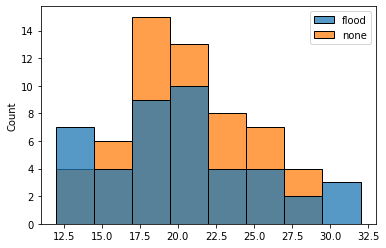

In [9]:
sns.histplot(x=article_len_array,hue=article_category_array)

In [10]:
# The max length of news articles is 6792, we need to decide on a way to feed in chunks of 512 tokens

In [11]:
tokenized_df = pd.DataFrame()
tokenized_df['ID'] = article_id_array
tokenized_df['tokenized_input_ids'] = tokenized_input_ids
tokenized_df['category'] = article_category_array

In [12]:
tokenized_df.head()

,ID,tokenized_input_ids,category
0,0,"[101, 5279, 1024, 5956, 14295, 5057, 2933, 199...",flood
1,1,"[101, 5595, 2086, 2006, 1010, 1996, 15179, 547...",none
2,2,"[101, 17763, 1024, 15179, 9451, 22382, 2053, 3...",flood
3,3,"[101, 5279, 2006, 2152, 9499, 2206, 10411, 142...",none
4,4,"[101, 2129, 1996, 6801, 15179, 5477, 2453, 808...",none


In [13]:
# 
#tokenized_df[tokenized_df['tokenized_input_ids'].apply(lambda x:len(x))<=512]

In [14]:
# There are many ways of dealing with texts with more 512 tokens. One of the easiest approach is to just take
#first 512 tokens for analysis. Let us try that

In [15]:
# changing the labels to 0 or 1
df['label'] = df['category'].apply(lambda x:1 if x=='flood' else 0)

In [16]:
df['category'].shape

(100,)

In [27]:
# Tokenize all of the tweets and map the tokens to their word IDs.
input_ids = []
attention_masks = []
labels_list = []

for i in range(df.shape[0]):
    if df.loc[i,'article_title'] == 'nan':
        continue
    encoded_dict = tokenizer.encode_plus(
                        df.loc[i,'article_title'],                      # article to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                       max_length = 34,           # Pad & truncate all sentences.
                        #truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
    
    #collecting labels as well
    labels_list.append(df.loc[i,'label'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_list)

# Print sentence 0, now as a list of IDs.
print('Original: ', df.loc[10,'article_title'])
print('Token IDs:', input_ids[10])

Original:  ACT Alliance Rapid Response Fund Egypt: Floods Emergency (RRF03/2020) - Egypt - ReliefWeb
Token IDs: tensor([  101,  2552,  4707,  5915,  3433,  4636,  5279,  1024, 14295,  5057,
         1006, 25269,  2546,  2692,  2509,  1013, 12609,  1007,  1011,  5279,
         1011,  4335,  8545,  2497,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [28]:
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks,labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   90 training samples
   10 validation samples


In [29]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [30]:
# Train our classification model using BertForSequenceClassification 

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
#model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [31]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [32]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [33]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [34]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [35]:

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        
        print(step)


        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
0
1
2
3
4
5

  Average training loss: 0.69
  Training epoch took: 0:01:04

Running Validation...
  Accuracy: 0.50
  Validation Loss: 0.67
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
0
1
2
3
4
5

  Average training loss: 0.61
  Training epoch took: 0:01:02

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.61
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
0
1
2
3
4
5

  Average training loss: 0.57
  Training epoch took: 0:00:57

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.56
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
0
1
2
3
4
5

  Average training loss: 0.54
  Training epoch took: 0:01:01

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.53
  Validation took: 0:00:02

Training complete!
Total training took 0:04:11 (h:mm:ss)


In [38]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.694614,0.668905,0.5,0:01:04,0:00:02
2,0.614927,0.606592,0.9,0:01:02,0:00:02
3,0.565539,0.562491,0.9,0:00:57,0:00:02
4,0.536802,0.532033,0.9,0:01:01,0:00:02


([<matplotlib.axis.XTick at 0x1c36bc42b50>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

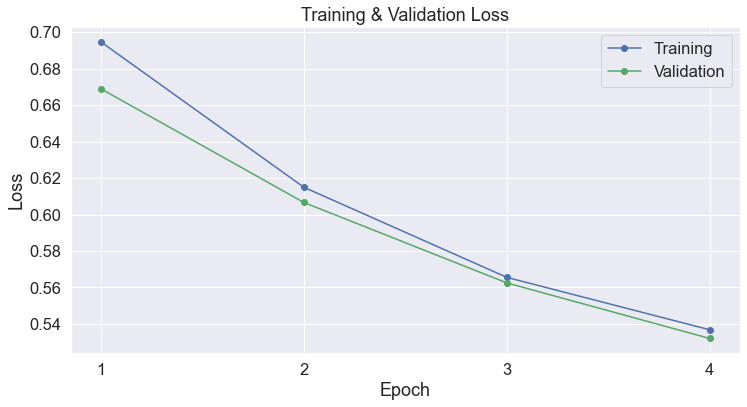

In [39]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])